In [19]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from sns_toolbox.networks import Network #, AdditionNetwork (This would import the code that we remake here
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse
from sns_toolbox.neurons import  NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.renderer import render

In [20]:
class MotorCircuit(Network):
    """
    Motor Unit netwok
    :param name:        Name of this network and all neurons prefix. Should be Hip/knee/ankle. Default is 'Hip'.
    :type name:         str, optional
    """
    def __init__(self,name='Hip', **kwargs):
        super().__init__(name=name,**kwargs)
        
        motor_neuron = NonSpikingNeuron(name="MN", color="green", membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-100.0)
        base_neuron = NonSpikingNeuron(name="Ia", color="red", membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)

        #CMM
        self.add_neuron(motor_neuron, name=name+'_MN_ext', color='lightcoral') 
        self.add_neuron(motor_neuron, name=name+'_MN_flx', color='mediumseagreen')    
        self.add_neuron(base_neuron, name=name+'_Ia_ext', color='lightcoral')
        self.add_neuron(base_neuron, name=name+'_Ia_flx', color='mediumseagreen')    
        self.add_neuron(base_neuron, name=name+'_RC_ext', color='lightcoral')
        self.add_neuron(base_neuron, name=name+'_RC_flx', color='mediumseagreen')   
        #Feedback neurons
        self.add_neuron(base_neuron, name=name+'_IaIN_ext', color='lightcoral') 
        self.add_neuron(base_neuron, name=name+'_IaIN_flx', color='mediumseagreen') 
        self.add_neuron(base_neuron, name=name+'_IbIN_ext', color='lightcoral') 
        self.add_neuron(base_neuron, name=name+'_IbIN_flx', color='mediumseagreen') 

        #define CMM synapses
        Ia_flx_Ia_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)
        Ia_ext_Ia_flx = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)
        Ia_flx_mn_ext = NonSpikingSynapse(max_conductance=2.0, reversal_potential=-100,e_hi=-40, e_lo=-60)
        Ia_ext_mn_flx = NonSpikingSynapse(max_conductance=2.0, reversal_potential=-100,e_hi=-40, e_lo=-60)
        mn_flx_rc_flx = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-40,e_hi=-10, e_lo=-100)
        mn_ext_rc_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-40,e_hi=-10, e_lo=-100)
        rc_ext_Ia_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)
        rc_flx_Ia_flx = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)
        rc_ext_mn_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-100,e_hi=-40, e_lo=-60)
        rc_flx_mn_flx = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-100,e_hi=-40, e_lo=-60)
        rc_flx_rc_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)
        rc_ext_rc_flx = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70,e_hi=-40, e_lo=-60)

        self.add_connection(Ia_flx_Ia_ext, name+"_Ia_flx", name+"_Ia_ext")
        self.add_connection(Ia_ext_Ia_flx, name+"_Ia_ext", name+"_Ia_flx")
        self.add_connection(Ia_flx_mn_ext, name+"_Ia_flx", name+"_MN_ext")
        self.add_connection(Ia_ext_mn_flx, name+"_Ia_ext", name+"_MN_flx")
        self.add_connection(mn_flx_rc_flx, name+"_MN_flx", name+"_RC_flx")
        self.add_connection(mn_ext_rc_ext, name+"_MN_ext", name+"_RC_ext")
        self.add_connection(rc_ext_Ia_ext, name+"_RC_ext", name+"_Ia_ext")
        self.add_connection(rc_flx_Ia_flx, name+"_RC_flx", name+"_Ia_flx")
        self.add_connection(rc_ext_mn_ext, name+"_RC_ext", name+"_MN_ext")
        self.add_connection(rc_flx_mn_flx, name+"_RC_flx", name+"_MN_flx")
        self.add_connection(rc_flx_rc_ext, name+"_RC_flx", name+"_RC_ext")
        self.add_connection(rc_ext_rc_flx, name+"_RC_ext", name+"_RC_flx")

        Ib2MN_flx = NonSpikingSynapse(max_conductance=1, reversal_potential=-10, e_hi=-40, e_lo=-60)
        Ib2MN_ext = NonSpikingSynapse(max_conductance=0.59, reversal_potential=-10, e_hi=-40, e_lo=-60)
        IaIn2Iaflx = NonSpikingSynapse(max_conductance=0.695, reversal_potential=-40, e_hi=-40, e_lo=-60)
        IaIn2Iaext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-40, e_hi=-40, e_lo=-60)

        self.add_connection(Ib2MN_ext, name+'_IbIN_ext', name+'_MN_ext')
        self.add_connection(Ib2MN_flx, name+'_IbIN_flx', name+'_MN_flx')
        self.add_connection(IaIn2Iaflx, name+'_IaIN_flx', name+'_Ia_flx')
        self.add_connection(IaIn2Iaext, name+'_IaIN_ext', name+'_Ia_ext')

        self.add_input(name+'_IaIN_ext')
        self.add_input(name+'_IaIN_flx')
        self.add_input(name+'_IbIN_ext')
        self.add_input(name+'_IbIN_flx')

        if name == 'Hip':
            self.add_neuron(base_neuron, name=name+'_II_IN_ext', color='lightcoral') 
            self.add_neuron(base_neuron, name=name+'_II_IN_flx', color='mediumseagreen') 
            self.add_input(name+'_II_IN_ext')
            self.add_input(name+'_II_IN_flx')

        self.add_output(name+'_MN_ext')
        self.add_output(name+'_MN_flx')

class Memory(Network):
    """
    Memory netwok
    :param name:        Name of this network and all neurons prefix. Should be Bump/Step/Gait. Default is 'Bump'.
    :type:              Can be Auto/Manual, Default is 'Auto'
        Auto network will automatically keep from resetting when it has a value, manual will autoreset unless the reset is suppressed otherwise
    """
    def __init__(self,name='Bump', type='Auto'):
        super().__init__(name=name)

        # Establish Key Variables

        Er = -60 # mV, resting potential, base state of neurons which they move off of
        Gm = 1 # uS
        R = 20 # mV, standing current applied to both integrator neurons to keep the system stable

        # Neuron variables based on table
        Cm = 5
        Es = -65 # Want synapse close to Er but a little less because close to modulatory is good but actually modulatory won't work
        delEs = Es-Er
        gs = -R/delEs

        intNeuron = NonSpikingNeuron(name="Int", color="lightgreen", membrane_capacitance=Cm, membrane_conductance=Gm, resting_potential=Er, bias=R)
        intSynapse = NonSpikingSynapse(max_conductance=gs, reversal_potential=Es, e_hi=-40, e_lo=-60)
        if name == 'Bump':
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=30, membrane_conductance=Gm, resting_potential=Er, bias=3)
        elif name == 'Gait':
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er)
        else:
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er, bias=3)
        # TriggerSynapse = NonSpikingSynapse(max_conductance=30, reversal_potential=0, e_hi=-35, e_lo=-55)
        InhSyn = NonSpikingSynapse(max_conductance=5, reversal_potential=-100, e_hi=-40, e_lo=-58) # max conductance mainly effects strength, reversal potential
        # mainly effects function, if inh then -100, if exc then 0
        # e_hi and e_lo determine the range over which the synapse activates
        ResetDoneSyn = NonSpikingSynapse(max_conductance=3, reversal_potential=-100, e_hi=-70, e_lo=-60)

        self.add_neuron(intNeuron, name+'_RMem')
        self.add_neuron(intNeuron, name+'_Mem')
        self.add_neuron(INNeuron, name+'_Reset')

        self.add_connection(intSynapse, name+'_RMem', name+'_Mem')
        self.add_connection(intSynapse, name+'_Mem', name+'_RMem')
        self.add_connection(InhSyn, name+'_Reset', name+'_Mem')
        self.add_connection(ResetDoneSyn, name+'_Mem', name+'_Reset')

        self.add_input(name+'_Reset', name='Input')

        if type == 'Auto':
            if name == 'Gait':
                AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-61)
            else:
                AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-57)
            self.add_connection(AntiResetSyn,name+'_Mem', name+'_Reset')
            if name == 'Bump':
                self.add_input(name+'_Mem', name='Stimulus')

        self.add_output(name+'_Mem')
        self.add_output(name+'_RMem')
        self.add_output(name+'_Reset')

def Ryan_net(cpg_gsyn=2.749, dt = 0.01, side='right'):

    net = Network('Kaiyu_2layer')

    Cm = 5
    Gm = 1
    Ena = 50
    Er = -60
    Sm = 0.2
    Sh = -0.6
    delEna = Ena
    Km = 1
    Kh = 0.5
    Em = -40
    Eh = -60
    delEm = Em
    delEh = Eh
    tauHmax = 350
    Gna = 1.5
    # reformat for sns-toolbox
    g_ion = [Gna]
    e_ion = [delEna]
    k_m = [Km]
    slope_m = [Sm]
    e_m = [delEm]
    k_h = [Kh]
    slope_h = [Sh]
    e_h = [delEh]
    tau_max_h = [tauHmax]

    # defining cpg neurons    
    HC_neuron = NonSpikingNeuronWithPersistentSodiumChannel(membrane_capacitance=Cm, membrane_conductance=Gm,
                                                                g_ion=g_ion,e_ion=e_ion,
                                                                k_m=k_m,slope_m=slope_m,e_m=e_m,
                                                                k_h=k_h,slope_h=slope_h,e_h=e_h,tau_max_h=tau_max_h,
                                                                name='HC',color='orange', resting_potential=Er , bias = 0.0)
    
    interneuron = NonSpikingNeuron(membrane_capacitance=Cm, membrane_conductance=Gm, resting_potential=Er, name="IN", color='blue')

    #define cpg synapses
    HC2IN = NonSpikingSynapse(max_conductance=cpg_gsyn, reversal_potential=-40, e_hi = -25, e_lo = -60)
    IN2HC = NonSpikingSynapse(max_conductance=cpg_gsyn, reversal_potential= -70, e_hi = -25, e_lo = -60)
    Gw = NonSpikingSynapse(max_conductance= 0.1, reversal_potential= -40, e_hi= -40, e_lo= -65)

    #add the RG neurons
    net.add_neuron(HC_neuron, 'RG_HC_ext')
    net.add_neuron(HC_neuron, 'RG_HC_flx')
    net.add_neuron(interneuron, 'RG_IN_ext')
    net.add_neuron(interneuron, 'RG_IN_flx')

    #connect the RG
    net.add_connection(HC2IN, 'RG_HC_ext', 'RG_IN_ext')
    net.add_connection(HC2IN, 'RG_HC_flx', 'RG_IN_flx')
    net.add_connection(IN2HC, 'RG_IN_ext', 'RG_HC_flx')
    net.add_connection(IN2HC, 'RG_IN_flx', 'RG_HC_ext')
    net.add_connection(Gw, 'RG_HC_ext', 'RG_HC_flx')
    net.add_connection(Gw, 'RG_HC_flx', 'RG_HC_ext')
    
    #add the hip PF layer
    net.add_neuron(HC_neuron, 'Hip_PF_HC_ext')
    net.add_neuron(HC_neuron, 'Hip_PF_HC_flx')
    net.add_neuron(interneuron, 'Hip_PF_IN_ext')
    net.add_neuron(interneuron, 'Hip_PF_IN_flx')

    #connect the Hip_PF
    net.add_connection(HC2IN, 'Hip_PF_HC_ext', 'Hip_PF_IN_ext')
    net.add_connection(HC2IN, 'Hip_PF_HC_flx', 'Hip_PF_IN_flx')
    net.add_connection(IN2HC, 'Hip_PF_IN_ext', 'Hip_PF_HC_flx')
    net.add_connection(IN2HC, 'Hip_PF_IN_flx', 'Hip_PF_HC_ext')

    #add the knee&ankle PF layer
    net.add_neuron(HC_neuron, 'KA_PF_HC_ext')
    net.add_neuron(HC_neuron, 'KA_PF_HC_flx')
    net.add_neuron(interneuron, 'KA_PF_IN_ext')
    net.add_neuron(interneuron, 'KA_PF_IN_flx')

    #connect the KA_PF
    net.add_connection(HC2IN, 'KA_PF_HC_ext', 'KA_PF_IN_ext')
    net.add_connection(HC2IN, 'KA_PF_HC_flx', 'KA_PF_IN_flx')
    net.add_connection(IN2HC, 'KA_PF_IN_ext', 'KA_PF_HC_flx')
    net.add_connection(IN2HC, 'KA_PF_IN_flx', 'KA_PF_HC_ext')

    # RG -> PF
    RG2PF_hip = NonSpikingSynapse(max_conductance=0.1,  reversal_potential=-40, e_hi=-40, e_lo=-60)
    RG2PF_KA = NonSpikingSynapse(max_conductance=0.05, reversal_potential=-40, e_hi=-40, e_lo=-60)
    
    net.add_connection(RG2PF_hip, 'RG_HC_ext', 'Hip_PF_HC_ext')
    net.add_connection(RG2PF_hip, 'RG_HC_flx', 'Hip_PF_HC_flx')
    net.add_connection(RG2PF_KA, 'RG_HC_ext', 'KA_PF_HC_ext')
    net.add_connection(RG2PF_KA, 'RG_HC_flx', 'KA_PF_HC_flx')

    # add inputs for cpgs
    net.add_input('RG_HC_ext')
    net.add_input('RG_HC_flx')

    #add the motor circuits
    Hip_motor_circuit = MotorCircuit(name='Hip')
    Knee_motor_circuit = MotorCircuit(name='Knee')
    Ankle_motor_circuit = MotorCircuit(name='Ankle')

    net.add_network(Hip_motor_circuit) 
    net.add_network(Knee_motor_circuit)
    net.add_network(Ankle_motor_circuit)

    # PF -> Ib IN inhibit
    pf2Ib = NonSpikingSynapse(max_conductance=2, reversal_potential=-60, e_hi=-59, e_lo=-60)

    net.add_connection(pf2Ib, 'Hip_PF_HC_flx','Hip_IbIN_ext')
    net.add_connection(pf2Ib, 'Hip_PF_HC_ext','Hip_IbIN_flx')
    net.add_connection(pf2Ib, 'KA_PF_HC_flx','Knee_IbIN_ext')
    net.add_connection(pf2Ib, 'KA_PF_HC_ext','Knee_IbIN_flx')
    net.add_connection(pf2Ib, 'KA_PF_HC_flx','Ankle_IbIN_ext')
    net.add_connection(pf2Ib, 'KA_PF_HC_ext','Ankle_IbIN_flx')

    # PF -> Motor Circuits
    PF2Ia = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-40, e_hi=-55, e_lo=-60)

    PF2HipMN_ext = NonSpikingSynapse(max_conductance=2.565, reversal_potential=-10, e_hi=-50, e_lo=-60)
    PF2HipMN_flx = NonSpikingSynapse(max_conductance=3.632, reversal_potential=-10, e_hi=-50, e_lo=-60)

    PF2KneeMN_ext = NonSpikingSynapse(max_conductance=2.1, reversal_potential=-40, e_hi=-50, e_lo=-60)
    PF2KneeMN_flx = NonSpikingSynapse(max_conductance=1.6, reversal_potential=-40, e_hi=-50, e_lo=-60)

    PF2AnkleMN_ext = NonSpikingSynapse(max_conductance=2.7, reversal_potential=-10, e_hi=-50, e_lo=-60)
    PF2AnkleMN_flx = NonSpikingSynapse(max_conductance=4.4, reversal_potential=-40, e_hi=-50, e_lo=-60)
    
    net.add_connection(PF2Ia, 'Hip_PF_HC_ext','Hip_Ia_ext')
    net.add_connection(PF2Ia, 'Hip_PF_HC_flx','Hip_Ia_flx')
    net.add_connection(PF2Ia, 'KA_PF_HC_ext','Knee_Ia_ext')
    net.add_connection(PF2Ia, 'KA_PF_HC_flx','Knee_Ia_flx')
    net.add_connection(PF2Ia, 'KA_PF_HC_ext','Ankle_Ia_ext')
    net.add_connection(PF2Ia, 'KA_PF_HC_flx','Ankle_Ia_flx')

    net.add_connection(PF2HipMN_ext, 'Hip_PF_HC_ext','Hip_MN_ext')
    net.add_connection(PF2HipMN_flx, 'Hip_PF_HC_flx','Hip_MN_flx')
    net.add_connection(PF2KneeMN_ext, 'KA_PF_HC_ext','Knee_MN_ext')
    net.add_connection(PF2KneeMN_flx, 'KA_PF_HC_flx','Knee_MN_flx')
    net.add_connection(PF2AnkleMN_ext, 'KA_PF_HC_ext','Ankle_MN_ext')
    net.add_connection(PF2AnkleMN_flx, 'KA_PF_HC_flx','Ankle_MN_flx')

    # feedback to PF and RG layers
    HipII_flx2RG_IN_ext = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-70, e_hi=-45, e_lo=-60)
    HipII_ext2RG_IN_flx = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-70, e_hi=-40, e_lo=-55)
    HipII_flx2Hip_PF_IN_ext = NonSpikingSynapse(max_conductance=0.5, reversal_potential=-70, e_hi=-30, e_lo=-50)
    HipII_ext2Hip_PF_IN_flx = NonSpikingSynapse(max_conductance=0.2, reversal_potential=-70, e_hi=-30, e_lo=-50)
    HipII_flx2KA_PF_IN_ext = NonSpikingSynapse(max_conductance=0.2, reversal_potential=-70, e_hi=-35, e_lo=-55)
    HipII_ext2KA_PF_IN_flx = NonSpikingSynapse(max_conductance=0.8, reversal_potential=-70, e_hi=-40, e_lo=-50)
    AnkleIb_ext2KA_PF_IN_ext = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-70, e_hi=-45, e_lo=-60)

    net.add_connection(HipII_flx2RG_IN_ext, 'Hip_II_IN_flx','RG_HC_ext')
    net.add_connection(HipII_ext2RG_IN_flx, 'Hip_II_IN_ext','RG_HC_flx')
    net.add_connection(HipII_flx2Hip_PF_IN_ext, 'Hip_II_IN_flx', 'Hip_PF_IN_ext')
    net.add_connection(HipII_ext2Hip_PF_IN_flx, 'Hip_II_IN_ext', 'Hip_PF_IN_flx')
    net.add_connection(HipII_flx2KA_PF_IN_ext, 'Hip_II_IN_flx', 'KA_PF_IN_ext')
    net.add_connection(HipII_ext2KA_PF_IN_flx, 'Hip_II_IN_ext', 'KA_PF_IN_flx')
    net.add_connection(AnkleIb_ext2KA_PF_IN_ext, 'Ankle_IbIN_ext', 'KA_PF_IN_ext')

    ankle_II_flx2ankleMNflx = NonSpikingSynapse(max_conductance=0.47, reversal_potential=-10, e_hi=-40, e_lo=-60)
    net.add_neuron(interneuron, 'Ankle_II_IN_flx')
    net.add_connection(ankle_II_flx2ankleMNflx ,'Ankle_II_IN_flx','Ankle_MN_flx')
    net.add_input('Ankle_II_IN_flx')

    net.add_output('RG_HC_ext')
    net.add_output('RG_HC_flx')
    net.add_output('Hip_PF_HC_ext')
    net.add_output('Hip_PF_HC_flx')
    net.add_output('KA_PF_HC_ext')
    net.add_output('KA_PF_HC_flx')


    # TESTING SENSOR VALUES
    base_neuron = NonSpikingNeuron(name="Ia", color="red", membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)
    net.add_neuron(base_neuron, name='Test_IaIN_flx', color='mediumseagreen')
    net.add_neuron(base_neuron, name='Test_IbIN_flx', color='mediumseagreen') 
    net.add_neuron(base_neuron, name='Test_IIIN_flx', color='mediumseagreen')
    net.add_neuron(base_neuron, name='Test_IaIN_ext', color='mediumseagreen')
    net.add_neuron(base_neuron, name='Test_IbIN_ext', color='mediumseagreen') 
    net.add_neuron(base_neuron, name='Test_IIIN_ext', color='mediumseagreen')

    net.add_input('Test_IaIN_ext')
    net.add_input('Test_IaIN_flx')
    net.add_input('Test_IbIN_ext')
    net.add_input('Test_IbIN_flx')
    net.add_input('Test_IIIN_ext')
    net.add_input('Test_IIIN_flx')

    net.add_output('Test_IaIN_ext')
    net.add_output('Test_IaIN_flx')
    net.add_output('Test_IbIN_ext')
    net.add_output('Test_IbIN_flx')
    net.add_output('Test_IIIN_ext')
    net.add_output('Test_IIIN_flx')
    
    
    
    if side == 'right': #or side == 'left'
        ###### BUMP NETWORK ######
        Bump_Storage = Memory(name='Bump', type='Auto')
        Step_Storage = Memory(name='Step', type='Manual')

        net.add_network(Bump_Storage)
        net.add_network(Step_Storage)

        # Add connection to stop the step counter from resetting itself
        AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-57)
        net.add_connection(AntiResetSyn, 'Bump_Mem','Step_Reset')

        StepCountSyn = NonSpikingSynapse(max_conductance=0.07, reversal_potential=0, e_hi=-35, e_lo=-48.7)
        net.add_connection(StepCountSyn, 'Hip_II_IN_flx', 'Step_Mem')

        # MAG STOP
        MagStop = NonSpikingNeuron(membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er, bias=3)
        net.add_neuron(MagStop, name='Mag_Stop', color='lightblue')
        StepModSyn = NonSpikingSynapse(max_conductance=20, reversal_potential=-60, e_hi=-38, e_lo=-43)
        net.add_connection(StepModSyn, 'Step_Mem', 'Mag_Stop')
        net.add_output('Mag_Stop')

        # MAG BOOST
        MagBoostNeuron = NonSpikingNeuron(membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er)
        net.add_neuron(MagBoostNeuron, name='Mag_Boost', color='lightblue')
        ModSyn = NonSpikingSynapse(max_conductance=50, reversal_potential=Er, e_hi=-55, e_lo=-59)
        net.add_connection(ModSyn, 'Mag_Stop','Mag_Boost')
        BumpExc = NonSpikingSynapse(max_conductance=0.07, reversal_potential=0, e_hi=-40, e_lo=-60)
        net.add_connection(BumpExc,'Bump_Mem', 'Mag_Boost')
        net.add_output('Mag_Boost')

        # RESET SYSTEM
        BoostReset = NonSpikingSynapse(max_conductance=0.57, reversal_potential=0, e_hi=-40, e_lo=-59.5)
        net.add_connection(BoostReset, 'Mag_Boost', 'Bump_Reset')
        # HipResetExc = NonSpikingSynapse(max_conductance=0.5, reversal_potential=0, e_hi=-65, e_lo=-52.5)
        #HipResetExc = NonSpikingSynapse(max_conductance=0.1, reversal_potential=0, e_hi=-30, e_lo=-50)
        #net.add_connection(HipResetExc, 'Hip_II_IN_flx', 'Bump_Reset')
        HipResetExc = NonSpikingSynapse(max_conductance=0.12, reversal_potential=0, e_hi=-30, e_lo=-50)
        net.add_connection(HipResetExc, 'Hip_II_IN_ext', 'Bump_Reset')

        # CONNECT TO MOTOR NEURONS
        KneeMNBoost = NonSpikingSynapse(max_conductance=20, reversal_potential=0, e_hi=-40, e_lo=-59.5)
        net.add_connection(KneeMNBoost, 'Mag_Boost', 'Knee_MN_flx')
        AnkleMNBoost = NonSpikingSynapse(max_conductance=10, reversal_potential=0, e_hi=-40, e_lo=-59.5)
        net.add_connection(AnkleMNBoost, 'Mag_Boost', 'Ankle_MN_flx')
        HipMNBoost = NonSpikingSynapse(max_conductance=20, reversal_potential=-100, e_hi=-40, e_lo=-59.5)
        net.add_connection(HipMNBoost, 'Mag_Boost', 'Hip_MN_flx')



        ############################## Gait NETWORK ############################
        # FAST AND SLOW NEURONS
        Fast = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60)
        net.add_neuron(Fast, name='Hip_Fast', color='lightblue')
        Slow = NonSpikingNeuron(membrane_capacitance=30.0, membrane_conductance=1, resting_potential=-60)
        net.add_neuron(Slow, name='Hip_Slow', color='lightblue')
        IIDeriv = NonSpikingSynapse(max_conductance=0.1, reversal_potential=0, e_hi=-40, e_lo=-60)
        net.add_connection(IIDeriv, 'Hip_II_IN_ext', 'Hip_Fast')
        net.add_connection(IIDeriv, 'Hip_II_IN_ext', 'Hip_Slow')

        # DERIVATIVE NETWORK
        net.add_neuron(base_neuron, name='RBack_IN', color='lightblue')
        net.add_output('RBack_IN')
        net.add_neuron(base_neuron, name='RFow_IN', color='lightblue')
        net.add_output('RFow_IN')
        DerivExc = NonSpikingSynapse(max_conductance=50, reversal_potential=0, e_hi=-40, e_lo=-60)
        DerivInh = NonSpikingSynapse(max_conductance=40, reversal_potential=-100, e_hi=-40, e_lo=-60)
        net.add_connection(DerivExc, 'Hip_Fast', 'RFow_IN')
        net.add_connection(DerivExc, 'Hip_Slow', 'RBack_IN')
        net.add_connection(DerivInh, 'Hip_Fast', 'RBack_IN')
        net.add_connection(DerivInh, 'Hip_Slow', 'RFow_IN')

        # ACTUAL OPERATORS
        BackNeuron = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60, bias=4.5)
        net.add_neuron(BackNeuron, name='Back_IN', color='lightblue')
        net.add_output('Back_IN')
        FowNeuron = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60, bias=12)
        net.add_neuron(FowNeuron, name='Fow_IN', color='lightblue')
        net.add_output('Fow_IN')
        RSuppression = NonSpikingSynapse(max_conductance=20, reversal_potential=-65, e_hi=-40, e_lo=-45.85)
        net.add_connection(RSuppression, 'RBack_IN', 'Back_IN')
        net.add_connection(RSuppression, 'RFow_IN', 'Fow_IN')
        HipExc = NonSpikingSynapse(max_conductance=0.05, reversal_potential=0, e_hi=-45, e_lo=-54)
        net.add_connection(HipExc, 'Hip_II_IN_ext', 'Back_IN')
        HipInh = NonSpikingSynapse(max_conductance=0.13, reversal_potential=-100, e_hi=-45, e_lo=-54)
        net.add_connection(HipInh, 'Hip_II_IN_ext', 'Fow_IN')

        # EXTRA FOW_IN OPERATOR
        FowSplitter = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60, bias=5)
        net.add_neuron(FowSplitter, name='Fow_Splitter', color='lightblue')
        HipSplitSyn = NonSpikingSynapse(max_conductance=20, reversal_potential=-65, e_hi=-40, e_lo=-48.5)
        net.add_connection(HipSplitSyn, 'Hip_II_IN_ext', 'Fow_Splitter')
        FowSplitSyn = NonSpikingSynapse(max_conductance=3, reversal_potential=-65, e_hi=-45, e_lo=-58)
        net.add_connection(FowSplitSyn, 'Fow_Splitter', 'Fow_IN')

        # Gait Write
        GaitRWrite = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60, bias = 10)
        net.add_neuron(GaitRWrite, name='Gait_RWrite', color='lightblue')
        net.add_input('Gait_RWrite', name='Stimulus')
        net.add_output('Gait_RWrite')
        GaitWrite = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60)
        net.add_neuron(GaitWrite, name='Gait_Write', color='lightblue')
        net.add_output('Gait_Write')
        WriteBlock = NonSpikingSynapse(max_conductance=20, reversal_potential=-60, e_hi=-40, e_lo=-60)
        net.add_connection(WriteBlock, 'Gait_RWrite', 'Gait_Write')
        WriteIn = NonSpikingSynapse(max_conductance=1, reversal_potential=0, e_hi=-45, e_lo=-58)
        net.add_connection(WriteIn, 'Back_IN', 'Gait_Write')
        net.add_connection(WriteIn, 'Fow_IN', 'Gait_Write')


        # GATE STORAGE
        Gait_Storage = Memory(name='Gait', type='Auto')
        net.add_network(Gait_Storage)
        ResetBase = NonSpikingSynapse(max_conductance=0.05, reversal_potential=0, e_hi=-45, e_lo=-60)
        net.add_connection(ResetBase, 'Gait_RWrite', 'Gait_Reset')
        WriteOut = NonSpikingSynapse(max_conductance=0.4, reversal_potential=0, e_hi=-35, e_lo=-57)
        net.add_connection(WriteOut,'Gait_Write', 'Gait_Mem')

        # OUTPUT INTERNEURONS
        OutExc = NonSpikingNeuron(membrane_capacitance=10.0, membrane_conductance=1, resting_potential=-60, bias = 19)
        net.add_neuron(OutExc, name='Out_Exc', color='lavender') # Neuron that slows down the RG
        net.add_output('Out_Exc')
        MemOutInh = NonSpikingSynapse(max_conductance=0.50, reversal_potential=-100, e_hi=-47.5, e_lo = -57.5)
        net.add_connection(MemOutInh, 'Gait_Mem', 'Out_Exc')
        OutInh = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)
        net.add_neuron(OutInh, name='Out_Inh', color='lavender') # Neuron that speeds up down the RG
        net.add_output('Out_Inh')
        MemOutExc = NonSpikingSynapse(max_conductance=0.5, reversal_potential=0, e_hi=-40, e_lo=-47.5)
        net.add_connection(MemOutExc, 'Gait_Mem', 'Out_Inh')
        RMemOutInh = NonSpikingSynapse(max_conductance=2, reversal_potential=-100, e_hi=-30, e_lo=-46) # Makes sure neither out neuron is firing when there is no gait change
        net.add_connection(RMemOutInh, 'Gait_RMem', 'Out_Exc')
        net.add_connection(RMemOutInh, 'Gait_RMem', 'Out_Inh')

        # OUTPUT TO RHYTHM GENERATORS
        GaitOutInh = NonSpikingSynapse(max_conductance=0.2, reversal_potential=-100, e_hi=-40, e_lo=-60)
        GaitOutExc = NonSpikingSynapse(max_conductance=0.06, reversal_potential=0, e_hi=-40, e_lo=-60)
        net.add_connection(GaitOutInh, 'Out_Inh', 'RG_HC_ext')
        net.add_connection(GaitOutInh, 'Out_Inh', 'RG_HC_flx')
        net.add_connection(GaitOutExc, 'Out_Exc', 'RG_HC_ext')
        net.add_connection(GaitOutExc, 'Out_Exc', 'RG_HC_flx')

        # RESET GATE SYSTEM
        GaitReset = NonSpikingSynapse(max_conductance=2, reversal_potential=0, e_hi=-40, e_lo=-59)
        net.add_connection(GaitReset, 'Mag_Boost', 'Gait_Reset')

        net.add_output('Hip_II_IN_flx')
        net.add_output('Hip_II_IN_ext')
        


    sns_model = net.compile(backend='numpy', dt = dt)

    render(net)
    
    return sns_model

def main():
    sns_model = Ryan_net()
    print(sns_model.num_inputs)
    print(sns_model.num_outputs)

if __name__ == '__main__':
    main()


28
39


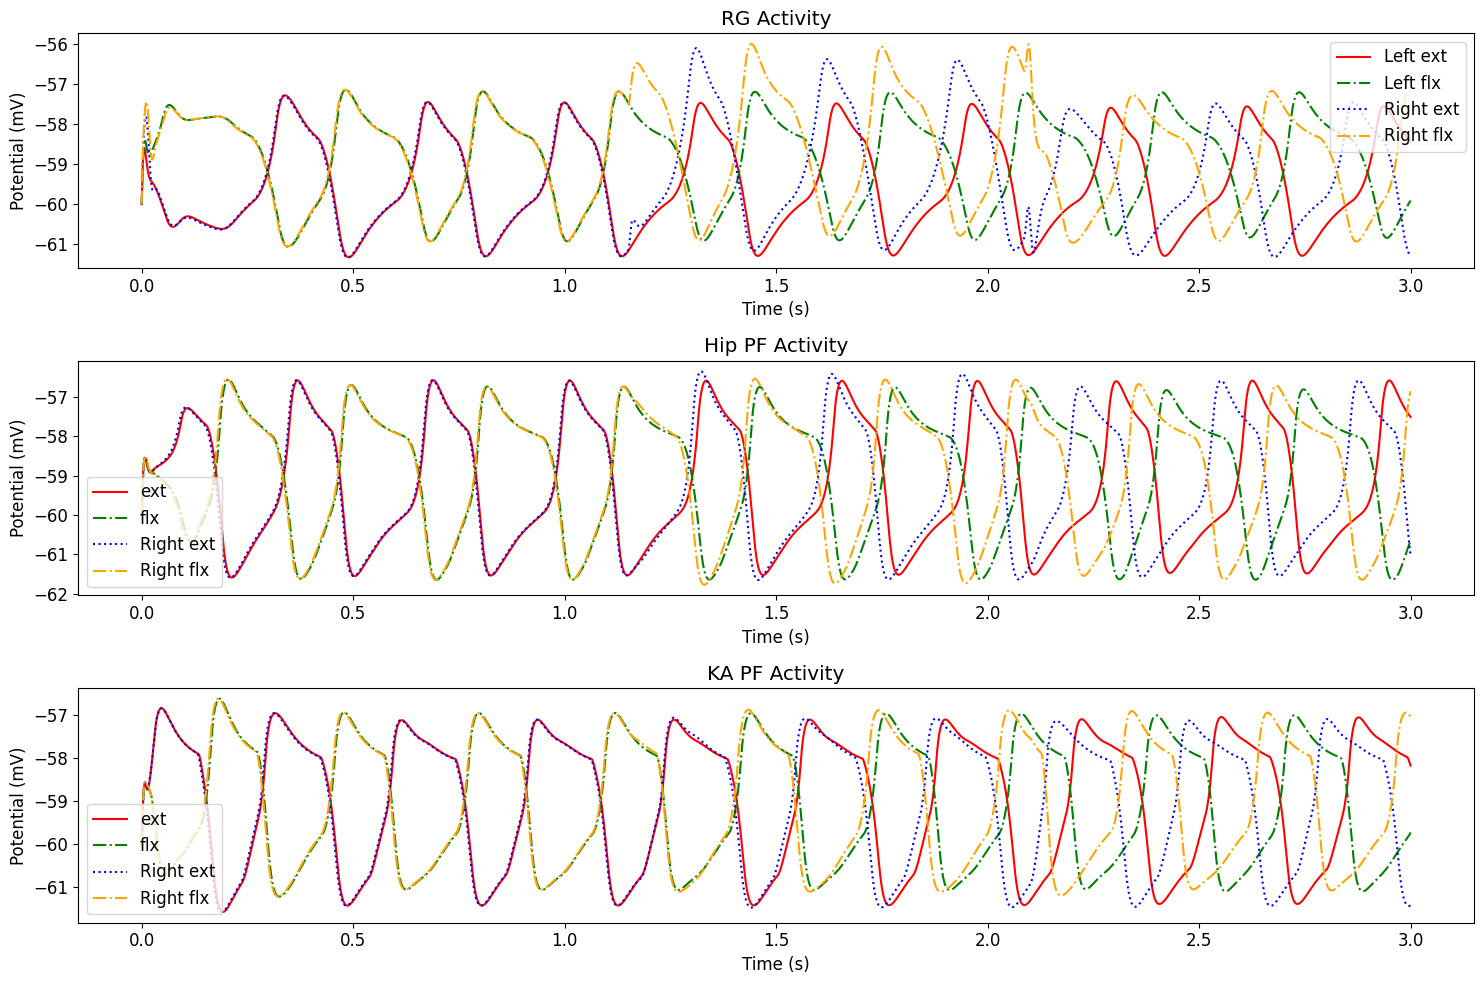

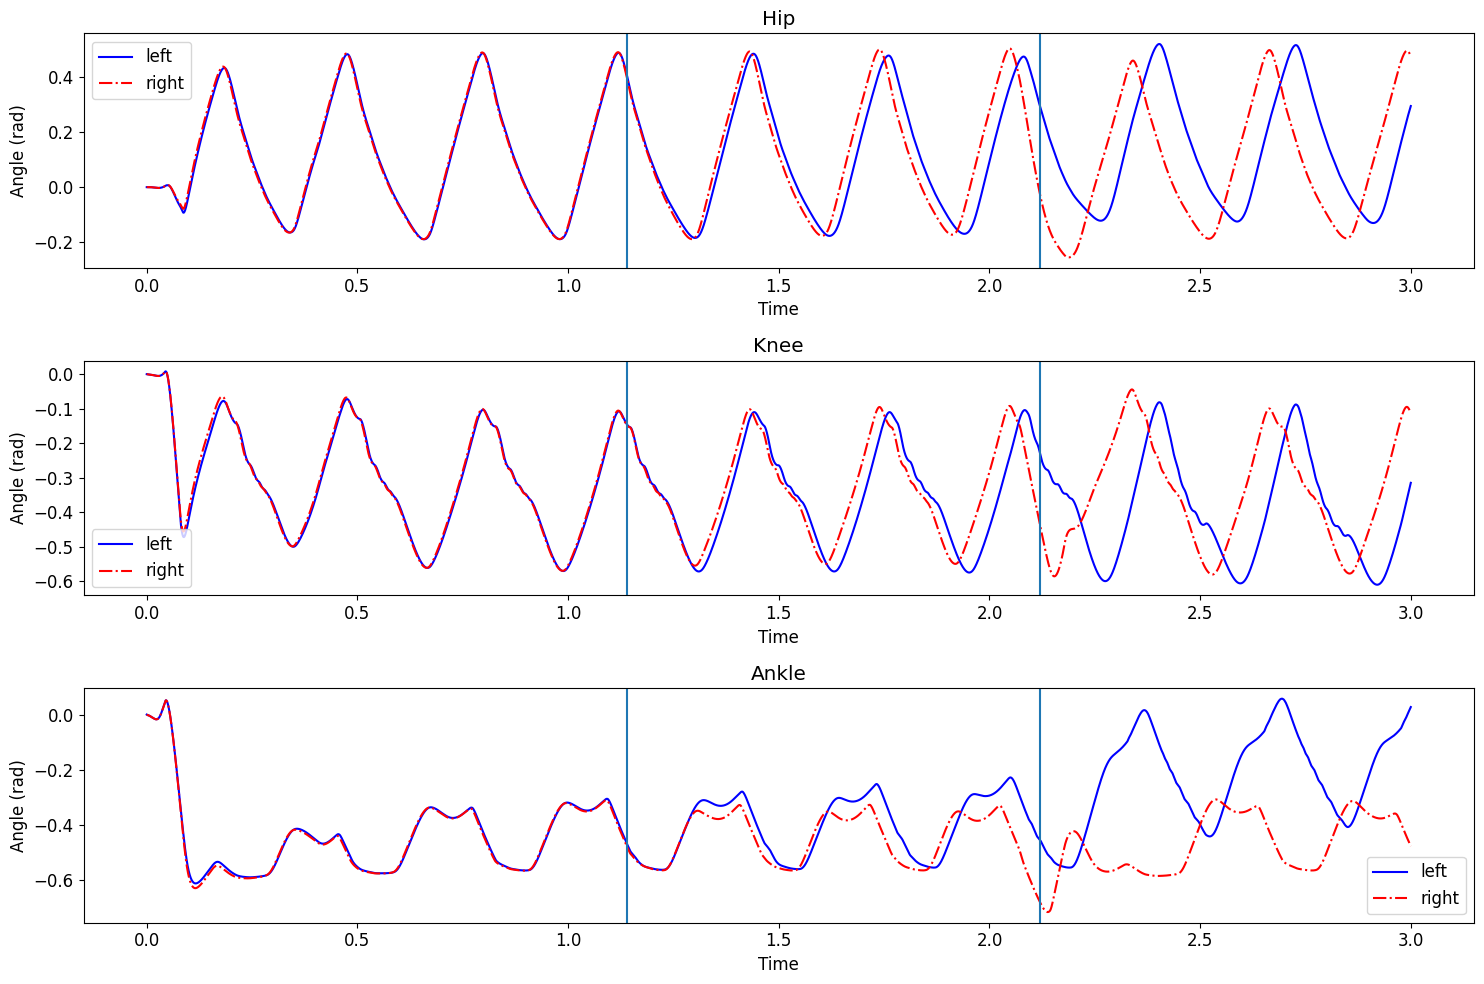

In [21]:
#from two_layer_cpg_sns_network import build_net
import mujoco
import numpy as np
import traceback
import mediapy as media
import matplotlib.pyplot as plt
import pandas as pd


def mujoco_model(xml_path):
    """
    loads in the mujoco model to be used as the physics model
    :param xml_path: path to the xml_l mujoco model
    :return:
    """

    # load in the mujoco model and simulation
    model = mujoco.MjModel.from_xml_path(xml_path)
    data = mujoco.MjData(model)

    mujoco.mj_forward(model, data)

    return model, data

def stim_to_act(stim):
    """
    converts from a neural potential to a muscle activation between 0 and 1
    :param stim: MN potential in mV
    :return: act: muscle activation between 0 and 1
    """
    # converted the stim2tenstion curve in animatlab
    steepness = 0.121465
    x_offset = -50
    y_offset = -0.002297
    amp = 1.0
    act = amp/(1 + np.exp(steepness*(x_offset-stim))) + y_offset
    act = np.clip(act, 0,1)
    return act

def run_sims(num_steps, xml_path, L_cpg_inputs, R_cpg_inputs, Ryan_ins):
    """
    runs the neural and physics models together for a specified number of time
    :param num_steps: number of steps taken in the simulations
    :param modeparams: takes an input of both the synaptic inputs and the gains for Ia feedback
                         g_syns = modeparams[:12]
                         gains = modeparams[12:]*1000

    :param xml_path: path to the Mujoco .xml_l file for the physics simulation
    :return: up to the user
    """

    mujoco_dt = 0.000075
    sns_dt = mujoco_dt *1000

    mujoco_sim, mujoco_data = mujoco_model(xml_path)
    mujoco_sim.opt.timestep = mujoco_dt

    L_sns_model = Ryan_net(dt=sns_dt, side='left')
    R_sns_model = Ryan_net(dt=sns_dt, side='right')
  
    # initializing vectors
    t = np.arange(0, num_steps)
    time = np.zeros([len(t)])

    Lnum_outputs = L_sns_model.num_outputs
    L_sns_sim_data = np.zeros([len(t), Lnum_outputs])
    L_sns_sim_data[0] = np.concatenate([[-100.0, -100.0], np.zeros(Lnum_outputs-2)-60])

    Rnum_outputs = R_sns_model.num_outputs
    R_sns_sim_data = np.zeros([len(t), Rnum_outputs])
    R_sns_sim_data[0] = np.concatenate([[-100.0, -100.0], np.zeros(Rnum_outputs-2)-60])

    # get the feedback for the first time_step
    Lnum_inputs = L_sns_model.num_inputs
    L_sns_inputs = np.concatenate([L_cpg_inputs[0,:], np.zeros(Lnum_inputs-2)])
    Rnum_inputs = R_sns_model.num_inputs
    R_sns_inputs = np.concatenate([R_cpg_inputs[0,:], np.zeros(Rnum_inputs-2)])

    # finding joint indices
    num_joints = mujoco_data.qpos.shape[0]
    if num_joints > 11:
        L_hip_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_hip_flx')+6
        L_knee_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_knee_flx')+6
        L_ankle_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_ankle_flx')+6
        R_hip_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_hip_flx')+6
        R_knee_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_knee_flx')+6
        R_ankle_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_ankle_flx')+6
    else:
        L_hip_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_hip_flx')
        L_knee_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_knee_flx')
        L_ankle_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'L_ankle_flx')
        R_hip_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_hip_flx')
        R_knee_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_knee_flx')
        R_ankle_joint_ind = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_JOINT, 'R_ankle_flx')

    #finding muscle indices
    L_hip_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_hip_flx')
    L_hip_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_hip_ext')
    L_knee_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_knee_flx')
    L_knee_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_knee_ext')
    L_ankle_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_ankle_flx')
    L_ankle_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'L_ankle_ext')
    R_hip_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_hip_flx')
    R_hip_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_hip_ext')
    R_knee_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_knee_flx')
    R_knee_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_knee_ext')
    R_ankle_flx = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_ankle_flx')
    R_ankle_ext = mujoco.mj_name2id(mujoco_sim, mujoco.mjtObj.mjOBJ_ACTUATOR, 'R_ankle_ext')

    L_hip_pos = np.zeros([len(t)])
    L_knee_pos = np.zeros([len(t)])
    L_ankle_pos = np.zeros([len(t)])
    R_hip_pos = np.zeros([len(t)])
    R_knee_pos = np.zeros([len(t)])
    R_ankle_pos = np.zeros([len(t)])

    L_hip_pos[0] = mujoco_data.qpos[L_hip_joint_ind]
    L_knee_pos[0] = mujoco_data.qpos[L_knee_joint_ind]
    L_ankle_pos[0] = mujoco_data.qpos[L_ankle_joint_ind]
    R_hip_pos[0] = mujoco_data.qpos[R_hip_joint_ind]
    R_knee_pos[0] = mujoco_data.qpos[R_knee_joint_ind]
    R_ankle_pos[0] = mujoco_data.qpos[R_ankle_joint_ind]

    make_vid = True
    frames = []
    framerate=60 
    renderer = mujoco.Renderer(mujoco_sim, 920,1280) 


    for i in range(1, num_steps):
        try:
            # take one step in neural sim
            L_sns_sim_data[i, :] = L_sns_model(L_sns_inputs)
            R_sns_sim_data[i, :] = R_sns_model(R_sns_inputs)
    
            # find the muscle excitation based on the mn activity from the previous timestep and set muscle activation (0-1)
            mujoco_data.act[L_hip_ext] = stim_to_act(L_sns_sim_data[i - 1, 0])
            mujoco_data.act[L_hip_flx] = stim_to_act(L_sns_sim_data[i - 1, 1])
            mujoco_data.act[L_knee_ext] = stim_to_act(L_sns_sim_data[i - 1, 2])
            mujoco_data.act[L_knee_flx] = stim_to_act(L_sns_sim_data[i - 1, 3])
            mujoco_data.act[L_ankle_ext] = stim_to_act(L_sns_sim_data[i - 1, 4])
            mujoco_data.act[L_ankle_flx] = stim_to_act(L_sns_sim_data[i - 1, 5])    
            mujoco_data.act[R_hip_ext] = stim_to_act(R_sns_sim_data[i - 1, 0])
            mujoco_data.act[R_hip_flx] = stim_to_act(R_sns_sim_data[i - 1, 1])
            mujoco_data.act[R_knee_ext] = stim_to_act(R_sns_sim_data[i - 1, 2])
            mujoco_data.act[R_knee_flx] = stim_to_act(R_sns_sim_data[i - 1, 3])
            mujoco_data.act[R_ankle_ext] = stim_to_act(R_sns_sim_data[i - 1, 4])
            mujoco_data.act[R_ankle_flx] = stim_to_act(R_sns_sim_data[i - 1, 5]) 

            # take one step in the physics sim
            mujoco.mj_step(mujoco_sim, mujoco_data)
            # record
            L_hip_pos[i] = mujoco_data.qpos[L_hip_joint_ind]
            L_knee_pos[i] = mujoco_data.qpos[L_knee_joint_ind]
            L_ankle_pos[i] = mujoco_data.qpos[L_ankle_joint_ind]
            R_hip_pos[i] = mujoco_data.qpos[R_hip_joint_ind]
            R_knee_pos[i] = mujoco_data.qpos[R_knee_joint_ind]
            R_ankle_pos[i] = mujoco_data.qpos[R_ankle_joint_ind]

            time[i] = mujoco_data.time
            # find the feedback from the physics sim
            # Ia neurons don't just have linear velocity feedback
            L_hip_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[L_hip_ext])*(np.abs(mujoco_data.actuator_velocity[L_hip_ext])**(0.6)) + 82
            L_hip_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[L_hip_flx])*(np.abs(mujoco_data.actuator_velocity[L_hip_flx])**(0.6)) + 82
            L_knee_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[L_knee_ext])*(np.abs(mujoco_data.actuator_velocity[L_knee_ext])**(0.6)) + 82
            L_knee_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[L_knee_flx])*(np.abs(mujoco_data.actuator_velocity[L_knee_flx])**(0.6)) + 82
            L_ankle_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[L_ankle_ext])*(np.abs(mujoco_data.actuator_velocity[L_ankle_ext])**(0.6)) + 82
            L_ankle_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[L_ankle_flx])*(np.abs(mujoco_data.actuator_velocity[L_ankle_flx])**(0.6)) + 82

            R_hip_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[R_hip_ext])*(np.abs(mujoco_data.actuator_velocity[R_hip_ext])**(0.6)) + 82
            R_hip_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[R_hip_flx])*(np.abs(mujoco_data.actuator_velocity[R_hip_flx])**(0.6)) + 82
            R_knee_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[R_knee_ext])*(np.abs(mujoco_data.actuator_velocity[R_knee_ext])**(0.6)) + 82
            R_knee_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[R_knee_flx])*(np.abs(mujoco_data.actuator_velocity[R_knee_flx])**(0.6)) + 82
            R_ankle_S_ext = 4.3*np.sign(mujoco_data.actuator_velocity[R_ankle_ext])*(np.abs(mujoco_data.actuator_velocity[R_ankle_ext])**(0.6)) + 82
            R_ankle_S_flx = 4.3*np.sign(mujoco_data.actuator_velocity[R_ankle_flx])*(np.abs(mujoco_data.actuator_velocity[R_ankle_flx])**(0.6)) + 82

            # Linear funcs converting feedback to applied current
            L_hip_Ia_feedback = [float(L_hip_S_ext)*1.294834-105.557769, float(L_hip_S_flx)*1.783516-145.162975]
            L_hip_Ib_feedback = [-0.290112*mujoco_data.actuator_force[L_hip_ext]+0.022660, -1.338718*mujoco_data.actuator_force[L_hip_flx]+0.089940]
            L_hip_II_feedback = [1091.147828068907*mujoco_data.actuator_length[L_hip_ext]-15.909879574199181, 2729.856579955123*mujoco_data.actuator_length[L_hip_flx]-88.569597408719915]
            L_knee_Ia_feedback = [float(L_knee_S_ext)*1.547175-126.883498, float(L_knee_S_flx)*0.468797-38.305320]
            L_knee_Ib_feedback = [-0.418349*mujoco_data.actuator_force[L_knee_ext]+0.102588, -0.251010*mujoco_data.actuator_force[L_knee_flx]+0.106523]
            L_ankle_Ia_feedback = [float(L_ankle_S_ext)*2.679300-219.277200, float(L_ankle_S_flx)*1.369509-111.88300]
            L_ankle_Ib_feedback = [-0.789629*mujoco_data.actuator_force[L_ankle_ext]+0.000643, -2.288017*mujoco_data.actuator_force[L_ankle_flx]+0.000893]
            L_ankle_II_feedback = [2769.711851*mujoco_data.actuator_length[L_ankle_flx]-82.017204] # only have flx II feedback

            R_hip_Ia_feedback = [float(R_hip_S_ext)*1.294834-105.557769, float(R_hip_S_flx)*1.783516-145.162975]
            R_hip_Ib_feedback = [-0.290112*mujoco_data.actuator_force[R_hip_ext]+0.022660, -1.338718*mujoco_data.actuator_force[R_hip_flx]+0.089940]
            R_hip_II_feedback = [1091.147828068907*mujoco_data.actuator_length[R_hip_ext]-15.909879574199181, 2729.856579955123*mujoco_data.actuator_length[R_hip_flx]-88.569597408719915]
            R_knee_Ia_feedback = [float(R_knee_S_ext)*1.547175-126.883498, float(R_knee_S_flx)*0.468797-38.305320]
            R_knee_Ib_feedback = [-0.418349*mujoco_data.actuator_force[R_knee_ext]+0.102588, -0.251010*mujoco_data.actuator_force[R_knee_flx]+0.106523]
            R_ankle_Ia_feedback = [float(R_ankle_S_ext)*2.679300-219.277200, float(R_ankle_S_flx)*1.369509-111.88300]
            R_ankle_Ib_feedback = [-0.789629*mujoco_data.actuator_force[R_ankle_ext]+0.000643, -2.288017*mujoco_data.actuator_force[R_ankle_flx]+0.000893]
            R_ankle_II_feedback = [2769.711851*mujoco_data.actuator_length[R_ankle_flx]-82.017204] # only have flx II feedback

            L_sns_inputs = np.concatenate([L_cpg_inputs[i,:],L_hip_Ia_feedback,L_hip_Ib_feedback, L_hip_II_feedback, L_knee_Ia_feedback, L_knee_Ib_feedback, L_ankle_Ia_feedback, L_ankle_Ib_feedback, L_ankle_II_feedback, L_hip_Ia_feedback, L_hip_Ib_feedback, L_hip_II_feedback]) #, L_hip_Ia_feedback, L_hip_Ib_feedback, L_hip_II_feedback
            R_sns_inputs = np.concatenate([R_cpg_inputs[i,:],R_hip_Ia_feedback,R_hip_Ib_feedback, R_hip_II_feedback, R_knee_Ia_feedback, R_knee_Ib_feedback, R_ankle_Ia_feedback, R_ankle_Ib_feedback, R_ankle_II_feedback, R_hip_Ia_feedback, R_hip_Ib_feedback, R_hip_II_feedback, Ryan_Ins[i,:]]) #, R_hip_Ia_feedback, R_hip_Ib_feedback, R_hip_II_feedback

            if make_vid == True: 
                if len(frames) < mujoco_data.time * framerate:
                    renderer.update_scene(mujoco_data, camera='fixed')
                    pixels = renderer.render().copy()
                    frames.append(pixels) 
    
            if np.abs(L_sns_sim_data[i,1])>100 or np.abs(L_sns_sim_data[i,0])>100:
                return 200.0
        except:
            traceback.print_exc()


    if make_vid == True:
        media.write_video('rat_hopping.mp4', frames, fps=framerate)

    R_sns_sim_data = R_sns_sim_data.T
    L_sns_sim_data = L_sns_sim_data.T


    return time, L_sns_sim_data, L_hip_pos, L_knee_pos, L_ankle_pos, R_hip_pos, R_knee_pos, R_ankle_pos, R_sns_sim_data

#def main():

end_time = 3 # seconds
num_steps = int(end_time/0.000075)

xml_path = 'rat_hindlimb_full_ground.xml'
# xml_path = 'kaiyu_mujoco_on_ground.xml'

Iapp = np.zeros([num_steps,2])
Ipert = np.zeros([num_steps,2])
Ipert[1,0] = 0 # to start cpg's
L_inputs = Iapp + Ipert

Iapp = np.zeros([num_steps,2])
Ipert = np.zeros([num_steps,2])
Ipert[1,0] = 0 # to start cpg's
R_inputs = Iapp + Ipert


###### Ryan Input ####################################################################################################################################
Ryan_Ins = np.zeros([num_steps,5])
dt = 0.075 # SNS dt
StimTime = 1140 #840 middle, 1045 min, 990/1330 max, 1130 for slight speed increase, 1230 for slight speed decrease
Stimulus = 17 # 21 to 15 for min to max stimulus
for i in range(1,int(6/dt)):
    Ryan_Ins[int(i+0/dt),[0,2,4]] = Ryan_Ins[int(i+0/dt),[0,2,4]] + 20 # Initialize memory
for i in range(1,int(15/dt)):
    Ryan_Ins[int(i+StimTime/dt),1] = Ryan_Ins[int(i+StimTime/dt),1] + Stimulus # Stimulus to mag network
    Ryan_Ins[int(i+StimTime/dt),0] = Ryan_Ins[int(i+StimTime/dt),0] - Stimulus # Gives greater consistency in latching of Bump_Mem neuron when Bump_Reset is suppressed
    Ryan_Ins[int(i+StimTime/dt),3] = Ryan_Ins[int(i+StimTime/dt),3] - Stimulus # -18 to -Lots for min to max stimulus


time, L_sns_sim_data, L_hip_pos, L_knee_pos, L_ankle_pos, R_hip_pos, R_knee_pos, R_ankle_pos, R_sns_sim_data = run_sims(num_steps, xml_path, L_inputs, R_inputs, Ryan_Ins)

fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].plot(time, L_sns_sim_data[:][6], color='red', label='Left ext')
axs[0].plot(time, L_sns_sim_data[:][7], color='green', label='Left flx', linestyle='-.')
axs[0].plot(time, R_sns_sim_data[:][6], color='blue', label='Right ext', linestyle=':')
axs[0].plot(time, R_sns_sim_data[:][7], color='orange', label='Right flx', linestyle='-.')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Potential (mV)')
axs[0].set_title('RG Activity')
axs[0].legend()

axs[1].plot(time, L_sns_sim_data[:][8], color='red', label='ext')
axs[1].plot(time, L_sns_sim_data[:][9], color='green', label='flx', linestyle='-.')
axs[1].plot(time, R_sns_sim_data[:][8], color='blue', label='Right ext', linestyle=':')
axs[1].plot(time, R_sns_sim_data[:][9], color='orange', label='Right flx', linestyle='-.')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Potential (mV)')
axs[1].set_title('Hip PF Activity')
axs[1].legend()

axs[2].plot(time, L_sns_sim_data[:][10], color='red', label='ext')
axs[2].plot(time, L_sns_sim_data[:][11], color='green', label='flx', linestyle='-.')
axs[2].plot(time, R_sns_sim_data[:][10], color='blue', label='Right ext', linestyle=':')
axs[2].plot(time, R_sns_sim_data[:][11], color='orange', label='Right flx', linestyle='-.')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Potential (mV)')
axs[2].set_title('KA PF Activity')
axs[2].legend()

plt.tight_layout()
#plt.savefig('SNS_data.jpeg')
#plt.clf()

plt.figure

fig2, axs2 = plt.subplots(3, 1, figsize=(15, 10))
axs2[0].plot(time, L_hip_pos, color='blue', label='left')
axs2[0].plot(time, R_hip_pos, color='red', linestyle='-.',label='right')      
axs2[0].set_xlabel('Time')
axs2[0].set_ylabel('Angle (rad)')
axs2[0].set_title('Hip')
axs2[0].axvline(StimTime/1000)
axs2[0].axvline(StimTime/1000 + 0.98)
axs2[0].legend()

axs2[1].plot(time, L_knee_pos, color='blue', label='left')
axs2[1].plot(time, R_knee_pos, color='red', linestyle='-.', label='right')
axs2[1].set_xlabel('Time')
axs2[1].set_ylabel('Angle (rad)')
axs2[1].set_title('Knee')
axs2[1].axvline(StimTime/1000)
axs2[1].axvline(StimTime/1000 + 0.98)
axs2[1].legend()

axs2[2].plot(time, L_ankle_pos, color='blue', label='left')
axs2[2].plot(time, R_ankle_pos, color='red',linestyle='-.', label='right')
axs2[2].set_xlabel('Time')
axs2[2].set_ylabel('Angle (rad)')
axs2[2].set_title('Ankle')
axs2[2].axvline(StimTime/1000)
axs2[2].axvline(StimTime/1000 + 0.98)
axs2[2].legend()

plt.tight_layout()
#plt.savefig('Joint_data.jpeg')
#plt.clf()


#    return

#if __name__ == '__main__':
#    main()

Text(0, 0.5, 'Neuron Potential (mV)')

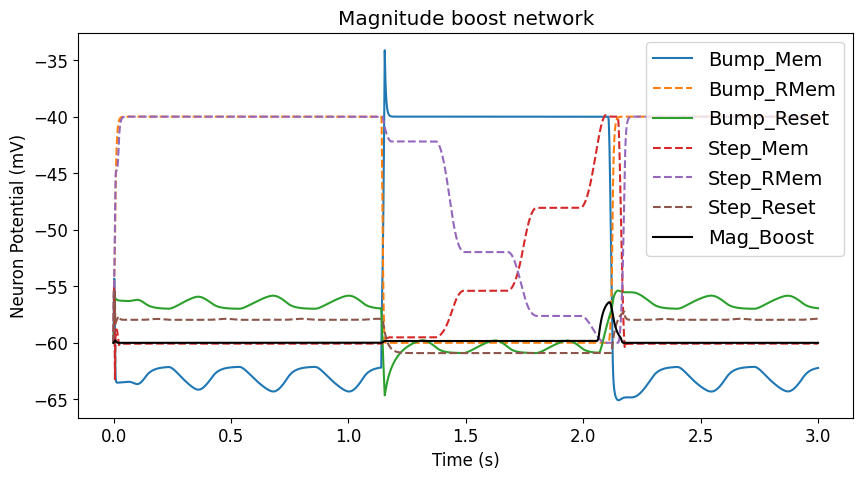

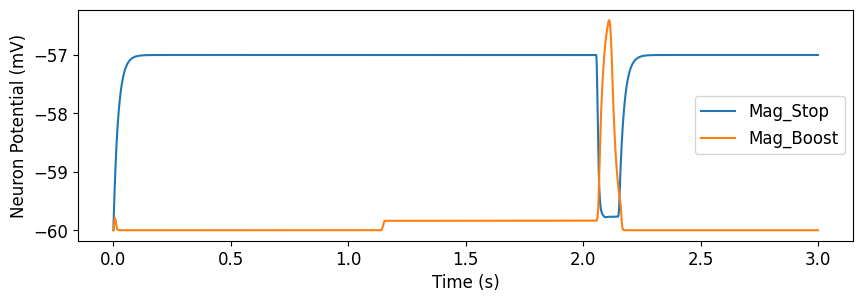

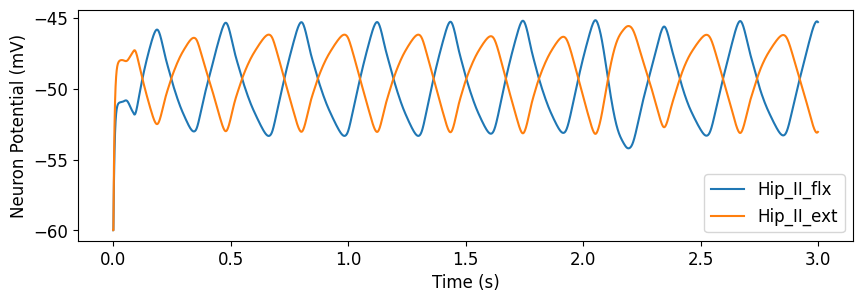

In [27]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,5))
plt.plot(time, R_sns_sim_data[:][18], label='Bump_Mem')
plt.plot(time, R_sns_sim_data[:][19], label='Bump_RMem',linestyle="dashed")
plt.plot(time, R_sns_sim_data[:][20], label='Bump_Reset')
plt.plot(time, R_sns_sim_data[:][21], label='Step_Mem',linestyle="dashed")
plt.plot(time, R_sns_sim_data[:][22], label='Step_RMem',linestyle="dashed")
plt.plot(time, R_sns_sim_data[:][23], label='Step_Reset',linestyle="dashed")
plt.plot(time, R_sns_sim_data[:][25], label='Mag_Boost', color='black')
plt.legend(loc='upper right', fontsize=14)
plt.title('Magnitude boost network')
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Neuron Potential (mV)', fontsize=12)

plt.figure(figsize=(10,3))
plt.plot(time, R_sns_sim_data[:][24], label='Mag_Stop')
plt.plot(time, R_sns_sim_data[:][25], label='Mag_Boost')
plt.legend(fontsize=12)
plt.xlabel('Time (s)')
plt.ylabel('Neuron Potential (mV)')
'''
plt.figure(figsize=(10,3))
plt.plot(time, R_sns_sim_data[:][39], label='Spiking_Counter')
plt.legend()
'''
plt.figure(figsize=(10,3))
plt.plot(time, R_sns_sim_data[:][37], label='Hip_II_flx')
plt.plot(time, R_sns_sim_data[:][38], label='Hip_II_ext')
#plt.plot(time, R_hip_pos-50, color='red', linestyle='-.',label='right') 
#plt.plot(time, R_sns_sim_data[:][25], label='Mag_Boost')
#plt.ylim(-55, -45)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Neuron Potential (mV)')


Text(0.5, 0, 'Time (s)')

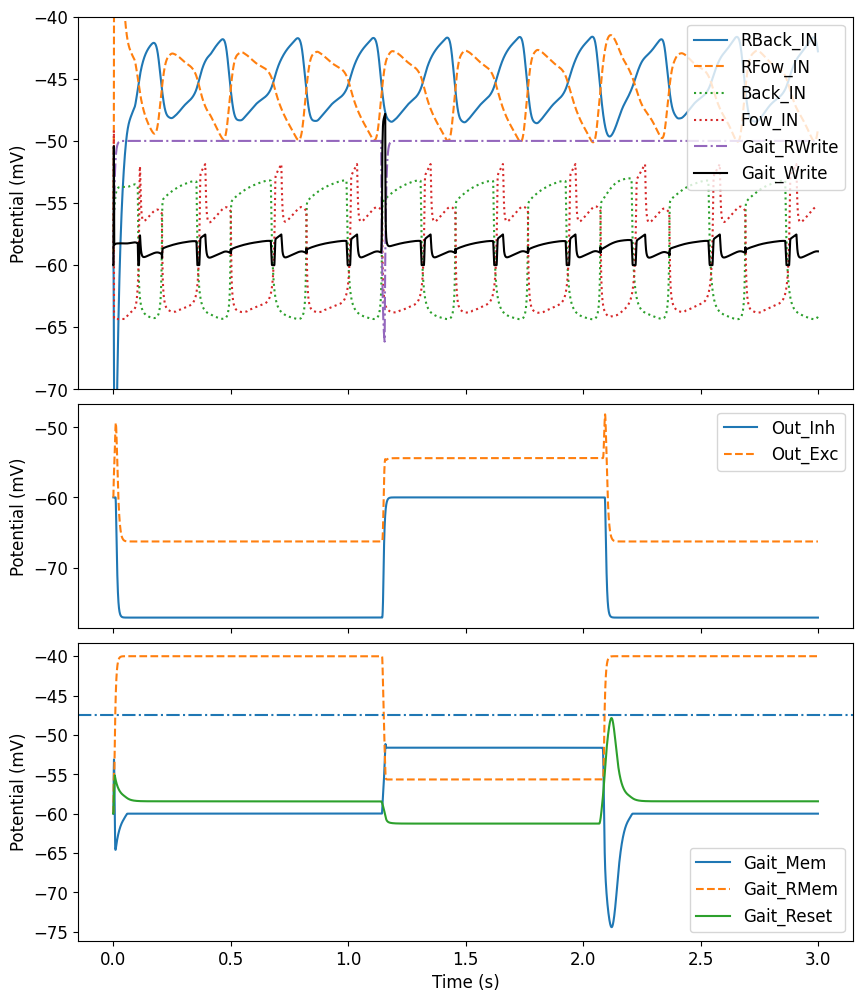

In [23]:
figg, axsg = plt.subplots(3, 1, figsize = (10,12), gridspec_kw={'height_ratios': [5, 3, 4]}, sharex=True)
figg.subplots_adjust(hspace=0.05)

axsg[0].plot(time, R_sns_sim_data[:][26], label='RBack_IN')
axsg[0].plot(time, R_sns_sim_data[:][27], label='RFow_IN',linestyle="dashed")
axsg[0].plot(time, R_sns_sim_data[:][28], label='Back_IN',linestyle="dotted")
axsg[0].plot(time, R_sns_sim_data[:][29], label='Fow_IN',linestyle="dotted")
axsg[0].plot(time, R_sns_sim_data[:][30], label='Gait_RWrite',linestyle="dashdot")
axsg[0].plot(time, R_sns_sim_data[:][31], label='Gait_Write',color='black')
axsg[0].set_ylim(-70,-40)
axsg[0].legend(loc='upper right')
axsg[0].set_ylabel('Potential (mV)')

axsg[1].plot(time, R_sns_sim_data[:][36], label='Out_Inh')
axsg[1].plot(time, R_sns_sim_data[:][35], label='Out_Exc', linestyle="dashed")
axsg[1].legend()
axsg[1].set_ylabel('Potential (mV)')

axsg[2].plot(time, R_sns_sim_data[:][32], label='Gait_Mem')
axsg[2].plot(time, R_sns_sim_data[:][33], label='Gait_RMem', linestyle="dashed")
axsg[2].plot(time, R_sns_sim_data[:][34], label='Gait_Reset')
#plt.plot(time, R_sns_sim_data[:][36], label='Out_Inh', linestyle="dashdot")
#plt.plot(time, R_sns_sim_data[:][35], label='Out_Exc', linestyle="dashdot")
axsg[2].axhline(-47.5, linestyle='dashdot')
axsg[2].legend()
axsg[2].set_ylabel('Potential (mV)')
axsg[2].set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

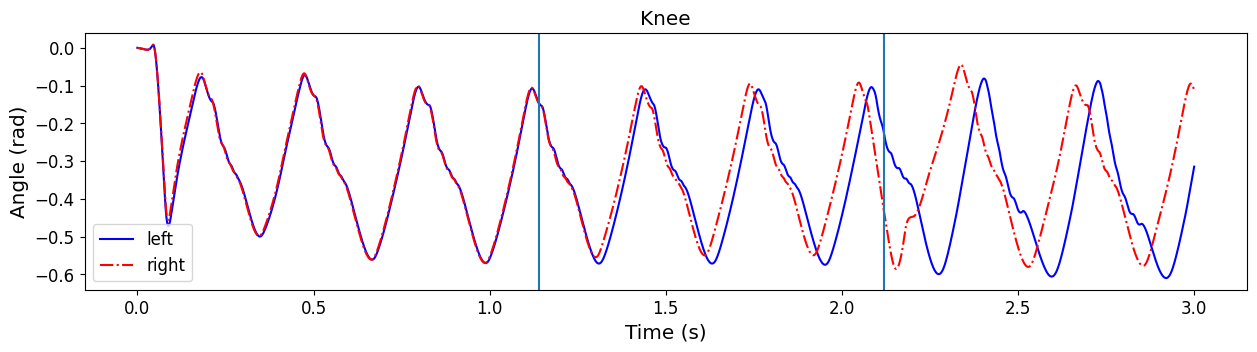

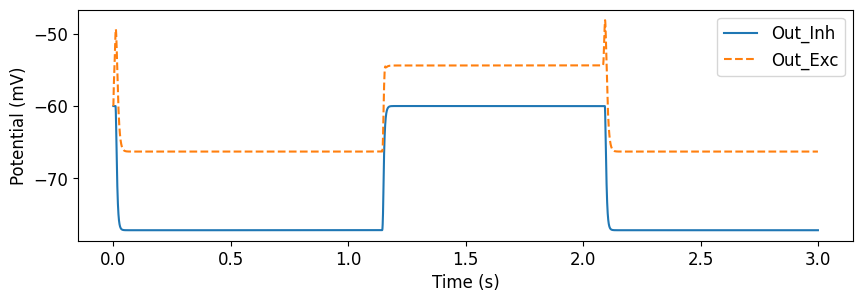

In [24]:
fig2, axs2 = plt.subplots(1, 1, figsize=(15, 10/3))
axs2.plot(time, L_knee_pos, color='blue', label='left')
axs2.plot(time, R_knee_pos, color='red', linestyle='-.', label='right')
axs2.set_xlabel('Time (s)', fontsize='large')
axs2.set_ylabel('Angle (rad)', fontsize='large')
axs2.set_title('Knee', fontsize='large')
axs2.axvline(StimTime/1000)
axs2.axvline(StimTime/1000 + 0.98)
axs2.legend()

figg, axsg = plt.subplots(1, 1, figsize=(10, 3))
axsg.plot(time, R_sns_sim_data[:][36], label='Out_Inh')
axsg.plot(time, R_sns_sim_data[:][35], label='Out_Exc', linestyle="dashed")
axsg.legend()
axsg.set_ylabel('Potential (mV)')
axsg.set_xlabel('Time (s)')